In [1]:
from keras import applications
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers.convolutional import Convolution2D
from keras import backend as K
import keras
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from img_loader import DatasetLoader
from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from sklearn.preprocessing import MinMaxScaler
import scipy.misc
from PIL import ImageEnhance
from keras.models import load_model, save_model
import cv2
from scipy.misc import toimage

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [4]:
dl = DatasetLoader('/home/lux/dev/Bachelor-2017/keras/dataset', 10)
model = load_model("/home/lux/Dropbox/HEIG/BACHELOR-2017-SAFE/vgg16_ft_cam_normal.h5")

DATASET LOADER] Discovering dataset...
DATASET LOADER] 
38 classes found.
 54305 images found.
DATASET LOADER] Shuffling order...
DATASET LOADER] 
Ready for loading!
 40728 for training and 13576 for testing


/usr/lib64/python3.5/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


DATASET LOADER] 
Max img loaded! 9 / 54305
DATASET LOADER] Loading completed!


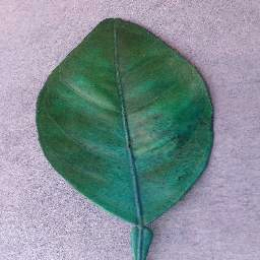

In [5]:
# Pre-process input
_, imgs, _ = dl.load_dataset()
input_img = imgs[2]
input_img = np.expand_dims(input_img, axis=0)
input_img.shape
toimage(input_img[0])

In [6]:
#Verify layer output 
print('inbound', model.get_layer('CAM').output.shape)

inbound (?, ?, ?, 512)


In [7]:
def get_outputs_generator(model, layer_name):
    """
    Gets the output generator of a specific layer of the model.

    :param model: The model
    :param layer_name: The layer's name
    :return: the output generator (a function)
    """
    layer_model = Model(
        input=model.input,
        output=model.get_layer(layer_name).output
    )

    return layer_model.predict

In [8]:
output_generator = get_outputs_generator(model, 'CAM')
layer_outputs = output_generator(input_img)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("CA...)`


In [11]:
layer_outputs[0].shape

(8, 8, 512)

In [12]:
#Grab the output of the layer:
output_generator = get_outputs_generator(model, 'CAM')
layer_outputs = output_generator(input_img)[0]
print('layer output shape',layer_outputs.shape)
img = layer_outputs[:, :, 0]
print('image shape', img.shape)
print('number of filters:', layer_outputs.shape[2])

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("CA...)`


layer output shape (8, 8, 512)
image shape (8, 8)
number of filters: 512


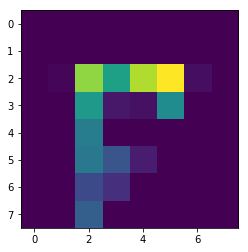

In [13]:
plt.imshow(img)

So as we see here the weights that we need are as model.get_layer("W").get_weights()[0][k_kernel][class_to_predict]

In [14]:
def reduce_opacity(im, opacity):
    """
    Returns an image with reduced opacity.
    Taken from http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/362879
    """
    if im.mode != 'RGBA':
        im = im.convert('RGBA')
    else:
        im = im.copy()
    alpha = im.split()[3]
    alpha = ImageEnhance.Brightness(alpha).enhance(opacity)
    im.putalpha(alpha)
    return im

In [15]:
def heatmap_generate(input_img, model, class_to_predict, layer_name, image_name=None):
   
    output_generator = get_outputs_generator(model, layer_name)
    layer_outputs = output_generator(np.expand_dims(input_img, axis=0))[0]
    heatmap = Image.new("RGBA", (224, 224), color=0)
    # Normalize input on weights
    w = MinMaxScaler((0.0, 1.0)).fit_transform(model.get_layer("W").get_weights()[0])

    for z in range(0, layer_outputs.shape[2]): # Iterate through the number of kernels
        img = layer_outputs[:, :, z]

        deprocessed = scipy.misc.toimage(cv2.resize(img, (224, 224))).convert("RGBA")
        deprocessed = reduce_opacity(deprocessed, w[z][class_to_predict])
        heatmap.paste(deprocessed, (0, 0), deprocessed)
    # heatmap = image.img_to_array(ImageOps.invert(heatmap.convert("RGB")).convert("RGBA"))
    # ImageOps.invert(heatmap.convert("RGB")).convert("RGBA").save("TMP.png", "PNG")
    heatmap.save("TMP.png", "PNG")
    heatmap = cv2.imread("TMP.png", cv2.CV_8UC3)  # FIXME: remove tmp file
    
    heatmap_colored = cv2.applyColorMap(np.uint8(heatmap), cv2.COLORMAP_JET)

    if image_name is not None:
        heatmap_colored = cv2.putText(heatmap_colored, image_name, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0),
                                      2)
    return Image.fromarray(cv2.resize(heatmap_colored, (224, 224)))

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("CA...)`


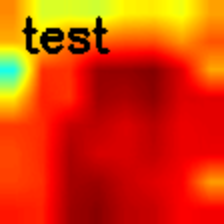

In [18]:
img = heatmap_generate(input_img[0], model, 0, 'CAM', image_name='test')
img

In [19]:
w = MinMaxScaler((0.0, 1.0)).fit_transform(model.get_layer("W").get_weights()[0])
print(w)
print(w[0])
print(w[0][0])

[[ 0.55503893  0.23364481  0.30236983 ...,  0.73318774  0.14848837
   0.79208684]
 [ 0.21053475  0.32648319  0.68785971 ...,  0.56825984  0.11914587
   0.5756647 ]
 [ 0.19844788  0.66695654  0.69302505 ...,  0.56083602  0.65409708
   0.62783563]
 ..., 
 [ 0.70602453  0.47804746  0.09439102 ...,  0.53214484  0.89763141
   0.42027137]
 [ 0.14595535  0.63317198  0.16128743 ...,  0.64255619  0.14276683
   0.06290439]
 [ 0.42767349  0.12542415  0.55979586 ...,  0.8156147   0.25752449
   0.73947275]]
[ 0.55503893  0.23364481  0.30236983  0.81430435  0.1742326   0.54519737
  0.08923084  0.72862196  0.51289314  0.79018199  0.46621454  0.68529481
  0.20568839  0.4953196   0.71465182  0.8108865   0.34759584  0.63392472
  0.11817923  0.27346143  0.081009    0.54500878  0.66239476  0.12304339
  0.30178541  0.17411789  0.21352923  0.11607739  0.53036857  0.20600428
  0.56745994  0.76053858  0.29246849  0.8436693   0.6710546   0.73318774
  0.14848837  0.79208684]
0.555039


In [20]:
model.get_layer("W").get_weights()[0]

array([[ 0.02673172, -0.07545575, -0.04073232, ...,  0.0573962 ,
        -0.08429908,  0.08672606],
       [-0.07113728, -0.04939621,  0.07363503, ...,  0.01186817,
        -0.0933743 ,  0.02165521],
       [-0.07457099,  0.04617397,  0.07516748, ...,  0.00981884,
         0.0720784 ,  0.03734126],
       ..., 
       [ 0.06962471, -0.00685241, -0.1024356 , ...,  0.00189869,
         0.14740005, -0.02506632],
       [-0.08948342,  0.03669072, -0.08258874, ...,  0.03237753,
        -0.08606867, -0.13251451],
       [-0.00945108, -0.10583308,  0.03564097, ...,  0.08015   ,
        -0.05057579,  0.07090678]], dtype=float32)